### Transfer Learning MobileNet ajout des blasts et smudge

In [1]:
%matplotlib inline
import numpy as np

import matplotlib.pyplot as plt
import cv2
import seaborn as sns

import pandas as pd
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential

from keras.applications.mobilenet import preprocess_input

from tensorflow.keras.callbacks import EarlyStopping
from keras.applications import MobileNet
from sklearn import metrics
import tensorflow as tf


#### Récupération de la base d'images et création jeu d'évaluation, de test et d'entrainement

In [2]:
data = pd.read_csv('../base_10_class.csv',index_col=0)

In [3]:
lst_classes = {'basophil':0,'blast':1,'eosinophil':2,
               'erythroblast':3,'ig':4,'lymphocyte':5,'monocyte':6,'neutrophil':7,'platelet':8,'smudge':9}

In [4]:
data['label'] = data['class'].apply(lambda cat: lst_classes[cat])

In [5]:
data.head()

,file_path,filename,class,label
0,../images_mendeley/PBC_dataset_normal_DIB/baso...,BA_100102.jpg,basophil,0
1,../images_mendeley/PBC_dataset_normal_DIB/baso...,BA_101381.jpg,basophil,0
2,../images_mendeley/PBC_dataset_normal_DIB/baso...,BA_101611.jpg,basophil,0
3,../images_mendeley/PBC_dataset_normal_DIB/baso...,BA_102039.jpg,basophil,0
4,../images_mendeley/PBC_dataset_normal_DIB/baso...,BA_102750.jpg,basophil,0


In [6]:
data_train, data_eval = train_test_split(data,test_size=0.1,random_state=123)
data_train, data_test = train_test_split(data_train,test_size=0.1,random_state=123)

##### Mise au format Tensor

In [7]:
def load_and_preprocess(img_filepath):
    img = tf.io.read_file(img_filepath)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [224,224]) # format nécessaire pour MobileNet
    img = tf.cast(img, tf.float32)
    img = preprocess_input(img) 
    return img

In [8]:
AUTO = tf.data.experimental.AUTOTUNE

In [9]:
dataset_train = tf.data.Dataset.from_tensor_slices((data_train['file_path'],data_train['label']))
dataset_test = tf.data.Dataset.from_tensor_slices((data_test['file_path'],data_test['label']))

dataset_train = (dataset_train.map(lambda x, y : [load_and_preprocess(x), y], num_parallel_calls=AUTO).prefetch(AUTO).shuffle(1000).batch(32))
dataset_test = (dataset_test.map(lambda x, y : [load_and_preprocess(x), y], num_parallel_calls=AUTO).prefetch(AUTO).shuffle(500).batch(32))

#### Transfer Learning avec modèle MobileNet
* Freeze de toutes les couches
* Couches Dense 1024, 512, 256 
* Dropout pour éviter overfitting
* Compilation avec Adam avec learning_rate de 10-4

In [10]:
# Création Callback pour stopper si stagnation
callback = EarlyStopping(monitor='val_loss', patience=3,restore_best_weights=True)

In [11]:
# Création d'un modèle MobileNet
def model_mobileNet():
    base_model = MobileNet(
        weights='imagenet',  
        input_shape=(224, 224, 3),
        include_top=False)  
    base_model.trainable = False
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(units=1024,activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(units=512,activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(units=256,activation='relu')(x)
    x = Dropout(0.5)(x)
    # A Dense classifier 
    outputs = Dense(units=10,activation='softmax')(x)
    model = Model(base_model.input, outputs)


    model.compile(optimizer='adam' ,loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [12]:
model = model_mobileNet()

In [13]:
#Entrainement
history = model.fit(dataset_train, epochs = 16, validation_data = dataset_test,callbacks=[callback])

Epoch 1/16
804/804 [==============================] - 805s 1s/step - loss: 1.3347 - accuracy: 0.5370 - val_loss: 0.6954 - val_accuracy: 0.7889
Epoch 2/16
804/804 [==============================] - 792s 985ms/step - loss: 0.8813 - accuracy: 0.7172 - val_loss: 0.5707 - val_accuracy: 0.8232
Epoch 3/16
804/804 [==============================] - 826s 1s/step - loss: 0.7744 - accuracy: 0.7527 - val_loss: 0.5226 - val_accuracy: 0.8428
Epoch 4/16
804/804 [==============================] - 788s 980ms/step - loss: 0.7125 - accuracy: 0.7760 - val_loss: 0.5414 - val_accuracy: 0.8372
Epoch 5/16
804/804 [==============================] - 787s 978ms/step - loss: 0.6840 - accuracy: 0.7894 - val_loss: 0.5077 - val_accuracy: 0.8456
Epoch 6/16
804/804 [==============================] - 788s 980ms/step - loss: 0.6437 - accuracy: 0.8000 - val_loss: 0.4732 - val_accuracy: 0.8530
Epoch 7/16
804/804 [==============================] - 788s 981ms/step - loss: 0.6278 - accuracy: 0.8063 - val_loss: 0.4621 - val_a

In [14]:
model.save_weights("mobilenet_10_weights")

#### Prédiction sur les données d'évaluation

In [ ]:
# model = model_mobileNet()
# model.load_weights("mobilenet_10_weights")

In [15]:
dataset_eval = tf.data.Dataset.from_tensor_slices((data_eval['file_path'],data_eval['label']))
dataset_eval = (dataset_eval.map(lambda x, y : [load_and_preprocess(x), y], num_parallel_calls=AUTO).prefetch(AUTO).batch(32))

In [16]:
model.evaluate(dataset_eval)

100/100 [==============================] - 86s 864ms/step - loss: 0.4604 - accuracy: 0.8674


[0.46036988496780396, 0.8673598170280457]

 * Bon score de 87% avec  un entrainement plus rapide que VGG16 ou ResNet

In [17]:
#Classes prédites
predict = model.predict(dataset_eval)

In [18]:
lst_classes = ['basophil','blast','eosinophil',
               'erythroblast','ig','lymphocyte','monocyte','neutrophil','platelet','smudge']
eval_predict_class = predict.argmax(axis = 1)
eval_predict_class_name = [lst_classes[i] for i in eval_predict_class]
eval_class_name = [lst_classes[i] for i in data_eval['label'] ]
print(metrics.classification_report( eval_class_name,eval_predict_class_name ))

              precision    recall  f1-score   support

    basophil       0.90      0.85      0.88       115
       blast       0.82      0.88      0.85       328
  eosinophil       0.92      0.95      0.93       316
erythroblast       0.84      0.89      0.86       208
          ig       0.75      0.74      0.75       358
  lymphocyte       0.85      0.89      0.87       478
    monocyte       0.86      0.71      0.78       265
  neutrophil       0.94      0.91      0.93       552
    platelet       0.98      0.98      0.98       254
      smudge       0.82      0.85      0.83       300

    accuracy                           0.87      3174
   macro avg       0.87      0.86      0.86      3174
weighted avg       0.87      0.87      0.87      3174



> Rappel plus faible sur les IG toujours, ainsi que les monocytes
>
> Score plus faible sur blast et smudge, compréhensible par des différences importantes sur ces types

In [20]:
pd.crosstab(pd.Series(eval_class_name, name='Réalité'),pd.Series(eval_predict_class_name, name='Prédiction'))

Prédiction,basophil,blast,eosinophil,erythroblast,ig,lymphocyte,monocyte,neutrophil,platelet,smudge
Réalité,,,,,,,,,,
basophil,98,0,0,0,14,1,1,1,0,0
blast,0,287,1,0,19,12,4,0,0,5
eosinophil,1,0,299,0,1,2,0,7,0,6
erythroblast,1,0,0,185,3,8,0,6,5,0
ig,5,32,3,2,265,12,16,10,0,13
lymphocyte,1,6,1,26,6,426,3,1,0,8
monocyte,2,14,7,0,26,7,187,3,0,19
neutrophil,1,2,14,1,16,9,2,503,1,3
platelet,0,0,0,2,0,2,0,0,249,1


> Confusion importante blaste/IG ainsi que monocyte/IG

In [21]:
# Récupère les cellules bien prédites => regarde la proba sur cette classe
compare = pd.DataFrame({'Réalité':data_eval['label'],'Prédiction':eval_predict_class}).reset_index()
predict_correct = compare[compare['Réalité']==compare['Prédiction']]

In [22]:
predict_by_class = []
for i in range(10):
    indexes = predict_correct[predict_correct['Réalité']==i].index
    pourcent = predict[indexes][:,i]
    predict_by_class.append(pourcent)

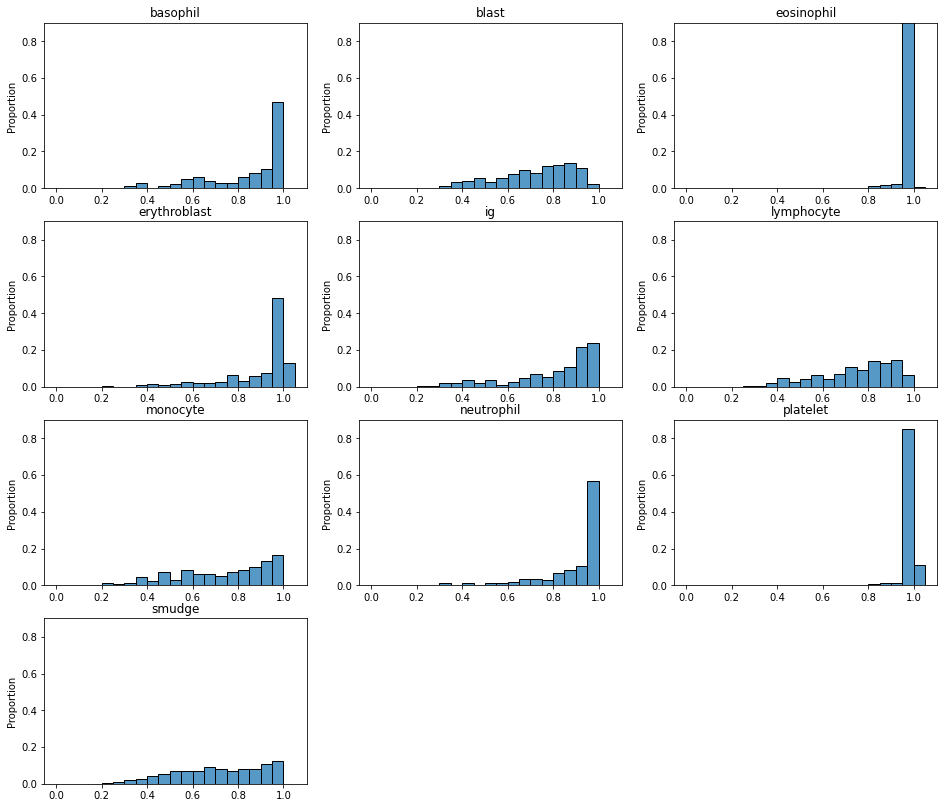

In [23]:
fig = plt.figure(figsize=(16,14))
for i in range(10):
        ax = fig.add_subplot(4, 3, i + 1)
        ax.set_ylim([0,0.9])
        plt.title(lst_classes[i])
        sns.histplot(x=predict_by_class[i],ax=ax,stat='proportion', bins = np.arange(0,1.1,0.05) )


### GRAD CAM

In [24]:
import gradcam_dataset

In [25]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)     

In [26]:
img_size = (255, 255)
last_conv_layer_name = "conv_pw_13_relu"

##### BASOPHIL

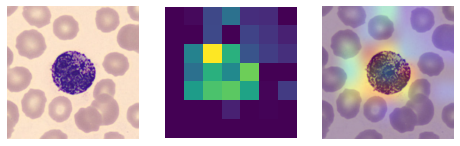

In [27]:
path = data[data['filename']=='BA_799126.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=0)

##### BLAST

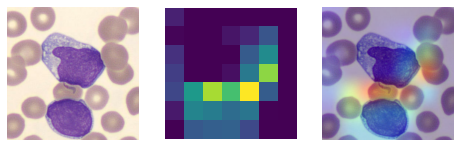

In [28]:
path = data[data['filename']=='BL_6995975.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=1)

##### EOSINOPHIL

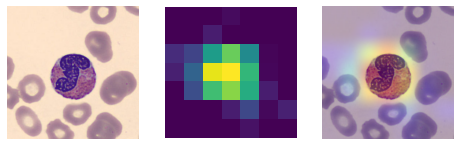

In [29]:
path = data[data['filename']=='EO_336686.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=2)

##### ERYTHROBLAST

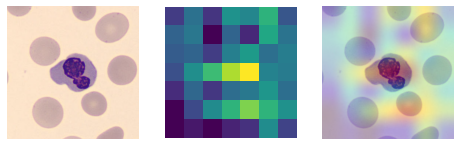

In [30]:
path = data[data['filename']=='ERB_763618.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=3)

##### IG

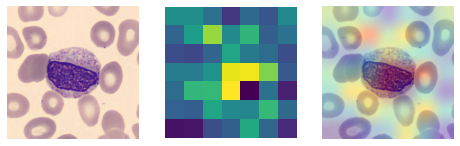

In [31]:
path = data[data['filename']=='MMY_353176.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=4)

##### LYMPHOCYTE

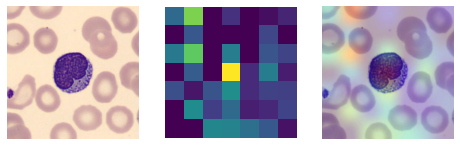

In [32]:
path = data[data['filename']=='LY_875873.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=5)

##### MONOCYTE

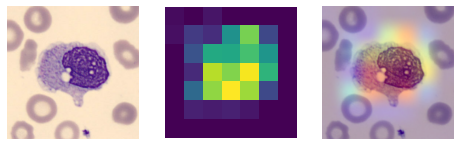

In [33]:
path = data[data['filename']=='MO_144054.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=6)

##### NEUTROPHIL

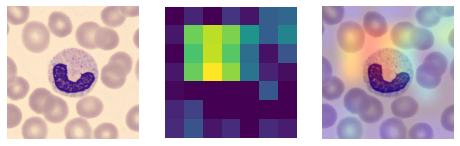

In [34]:
path = data[data['filename']=='BNE_495973.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=7)

##### PLATELET

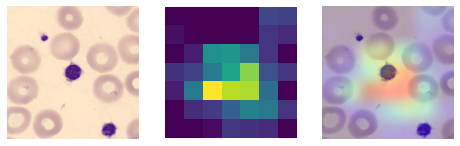

In [35]:
path = data[data['filename']=='PLATELET_57415.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=8)

##### SMUDGE

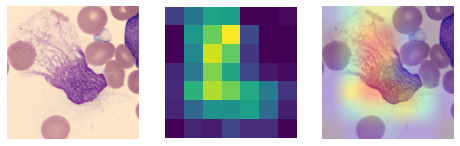

In [36]:
path = data[data['filename']=='SMU_13827002.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=9)